# This Notebook will include graphical analysis of Amazon review data

Source:

Justifying recommendations using distantly-labeled reviews and fined-grained aspects.

Jianmo Ni, Jiacheng Li, Julian McAuley.

Empirical Methods in Natural Language Processing (EMNLP), 2019.

https://nijianmo.github.io/amazon/index.html

http://deepyeti.ucsd.edu/jianmo/amazon/index.html

------------------------------

Sentiment analysis code shall be later on transfered to .py files for easy execution

---------------

In [116]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [3]:
# read data
path = "./data/AMAZON_FASHION_5.json"

data = pd.read_json(path, lines = True)

In [8]:
# get first look
print(f"Data has {len(data)} datapoints.")
print(f"Data has {len(data.columns)} Columns.")

print("Columns:")
print(list(data.columns))

Data has 3176 datapoints.
Data has 12 Columns.
Columns:
['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote', 'image']


In [9]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
1,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Black (3746...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
2,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Gray L...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
3,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue (37867...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
4,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Pink'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN


Most saved rating is 5 with 2158 datapoints.
Least saved rating is 2 with 93 datapoints.


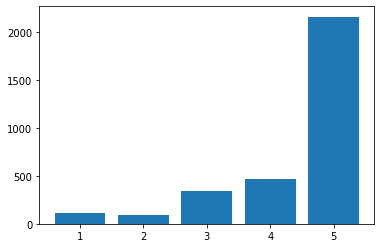

In [103]:
# how many datapoints per rating
rating_count = {}
all_ratings = sorted(data["overall"].unique())


for rating in all_ratings:
    
    rating_count[rating] = len(data[data["overall"] == rating])

# data information
most_rated = max(rating_count, key = rating_count.get)
least_rated = min(rating_count, key = rating_count.get)
print(f"Most saved rating is {most_rated} with {rating_count[most_rated]} datapoints.")
print(f"Least saved rating is {least_rated} with {rating_count[least_rated]} datapoints.")

# show graph
plt.bar(list(rating_count.keys()), list(rating_count.values()))
plt.show()

-----------

# provisionally Conclusion

Sample Data is highly imbalanced.

For now there should be used a sub_dataset with evenly distributed data.

This effect should be considered when using whole dataset

------------

In [123]:
# create balanced dataset by min count class (function from: https://stackoverflow.com/questions/45839316/pandas-balancing-data)
data_balanced = data[data["overall"] == least_rated]
remain_ratings = [i for i in all_ratings if i != least_rated]


for remain_rating in remain_ratings:
    
    # append data
    data_balanced = data_balanced.append(data[data["overall"] == remain_rating][:rating_count[least_rated]])

# shuffle dataframe
data_balanced = shuffle(data_balanced).reset_index(drop = True)

-------

# Now start Sentiment analysis

-------